# Pokemon Generator

### Part 1: CNN for the categorisation of Pokemon stats
This part of the program is designed to accept the image of a Pokemon character and predict the main 4 characteristics of the Pokemon: Height, Weight, Type1, Type2, Weakness. The CNN will be used to categorise the newly generated Pokemon output from the GAN in Part 2.


### Part 2: GAN for the creation of a brand new Pokemon 
The goal of the GAN is to train two seperate networks, a Generator and a Discriminator. One network aims to manipulate an image of pure noise to a realistic image of a Pokemon, while the other attempts to distinguish between 'real' and 'fake' images from the original dataset and the Generator network. The two networks will continue to learn as they battle, with the Generator producing more and more realistic images for the Discriminator to classify. 

### Part 3: Using the CNN to categorise a new 'Pokemon'
The outputs from our experiment will be displayed, showing both the new 'Pokemon' that has been created as well as it's Height, Weight, Type1, Type2 and Weakness stats. 

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [25]:
'''

from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from tqdm import tqdm
from keras.utils import to_categorical

'''

'\n\nfrom __future__ import print_function, division\n\nfrom keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D\nfrom keras.layers import BatchNormalization, Activation, ZeroPadding2D\nfrom keras.layers.advanced_activations import LeakyReLU\nfrom keras.layers.convolutional import UpSampling2D, Conv2D\nfrom keras.models import Sequential, Model\nfrom keras.optimizers import Adam\nfrom tqdm import tqdm\nfrom keras.utils import to_categorical\n\n'

In [26]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd

from PIL import Image
import os 
import csv

## Importing the Pokemon images

There are 809 official Pokemon designed for the original Pokemon games and the images from this project are available online for free. Over the lifetime of the Pokemon franchise, there have been many generations and artwork renditions. The two most clear and complete datasets were provided by https://www.pokemon.com/us/pokedex/ and these have been used for this project. 
 
### Datasets
- small:  contains 120x120 pixel title pictures for each Pokemon from original designs
- alt:    contains 215x215 pixel pictures for each Pokemon from digitally remastered designs
- big:    contains 475x475 pixel, high-res versions of 386 Pokemon from the alt dataset
- extra:  contains varying sized images with additional view angles of Pokemon in varying styles

In [27]:
images = []

file_paths = ["Dataset/small/", "Dataset/alt/", "Dataset/extra/", "Dataset/big/"]
rgb_white = 255
temp_training_data = []
name_label_data = []
img_size = 60

def importPokeImages(path):
    for img in os.listdir(path):
    
        if(img[-4:].lower() == ".png" or img[-4:].lower() == ".jpg"):
            image = np.array(Image.open(path + img).convert("RGBA").resize((img_size, img_size)))
            r, g, b, a = np.rollaxis(image, axis=-1)
            # Handelling image whitespace
            r[a == 0] = rgb_white
            g[a == 0] = rgb_white
            b[a == 0] = rgb_white 
            image = np.dstack([r, g, b])

            # Append image to set
            temp_training_data.append(image)

            # Append | flipped image to set
            temp_training_data.append(np.fliplr(image))

            # Append -- flipped image to set
            temp_training_data.append(np.flipud(image))

            # Append double flipped image to set
            temp_training_data.append(np.fliplr(np.flipud(image)))
            
            
            # Append label data
            if(" " in img[:-4]):
                for x in range(4):
                    name_label_data.append(img[:-4][:img[:-4].find(" ")].capitalize())
                    
            elif("-" in img[:-4]):
                for x in range(4):
                    name_label_data.append(img[:-4][:img[:-4].find("-")].capitalize())
            else:
                for x in range(4):
                    name_label_data.append(img[:-4].capitalize())
             


            
# Importing each dataset - comment out if neccessary 
importPokeImages(file_paths[0])
importPokeImages(file_paths[1])
importPokeImages(file_paths[2])
importPokeImages(file_paths[3])

training_data = np.array(temp_training_data).reshape(-1, img_size, img_size, 3) 

## Dataset augmentation
During the import process, each of the images imported have been transformed into three new versions for the network to learn from. This allows us to use 4x as much training data for our network to learn from for our prediction. As we are only concerned about classification at this stage, the orientation of the Pokemon is not important. 

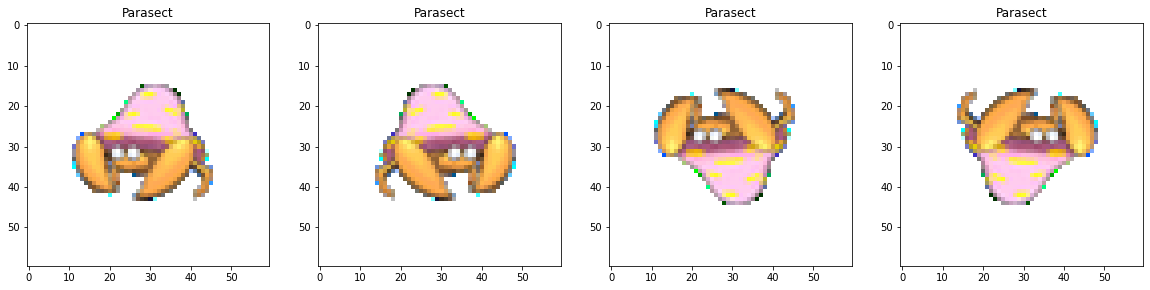

In [33]:
plt.figure(figsize=(20, 5))

# Original image
plt.subplot(1,4,1)
plt.title(name_label_data[0])
plt.imshow(training_data[0])

# Flipped | image
plt.subplot(1,4,2)
plt.title(name_label_data[1])
plt.imshow(training_data[1])

# Flipped -- image
plt.subplot(1,4,3)
plt.title(name_label_data[2])
plt.imshow(training_data[2])

# Double flipped image
plt.subplot(1,4,4)
plt.title(name_label_data[3])
plt.imshow(training_data[3])

plt.show()

## Importing the Pokemon stats

There are 809 official Pokemon which have been allocated many stats, however we will only focus on two of these attributes:
 - Type 1
 - Type 2
 
These stats will be used as the outputs for the CNN, although more are available for future development.

In [29]:
import pandas as pd

pokemon = pd.read_csv('Dataset/pokemon.csv')

pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


# Extracting Pokemon stat data
There are 18 seperate 'Types' that a Pokemon can be and each Pokemon has either one or two types.
Each of the types are defined below in both String and One-Hot form. The One-Hot encoding of this data makes it much easier for a neural network to categorise and find trends in data. Simply, string data is too inconsistent for trend analysis. 

In [30]:
types = ["Bug","Dark","Dragon","Electric","Fairy","Fighting",
        "Fire","Flying","Ghost","Grass","Ground","Ice",
        "Normal","Poison","Psychic","Rock","Steel","Water"]


# Method to decode the One Hot encoding of types into a readable string
def oh_decoder(my_type):
    type1= "NULL" 
    type2 = "NULL"
    
    for x in range(len(my_type)):
        if(my_type[x] == 1 and type1 == "NULL"):
            type1 = types[x]
        elif(my_type[x] == 1):
            type2 = types[x]
            
    
    return str(type1) + " / " + str(type2);

# One-Hot Encoding
Each of the pokemon images imported to the program are associated to one name label. These name labaled will be used to search through a Pokemon csv file with all associated stats. Once found, the One-Hot encoded types will be stored in a seperate list. When a Pokemon has two types, the one-hot encoded types will be combined in order to prevent multiple entries for each Pokemon. 

In [31]:
oh_lables = np.zeros((len(name_label_data),len(types)))


# Loop through each imported pokemon image
for x in range(len(name_label_data)):
 
    # Find the related Pokemon from the CSV file (there are multiple with the same single Poke ID)
    for y in range(len(pokemon)):
        if(name_label_data[x].lower() == str(pokemon['Name'][y].lower())):
            
            # For Pokemon with only ONE Type
            if(str(pokemon['Type 2'][y]) == "NaN"):
                for z in range(len(types)):
                    if(types[z] == pokemon['Type 1'][y]):
                        oh_lables[x][z] = 1
                       
            # For Pokemon with TWO types        
            else:
                for z in range(len(types)):
                    if(types[z] == pokemon['Type 1'][y]):
                        oh_lables[x][z] = 1
                        
                    if(types[z] == pokemon['Type 2'][y]):
                        oh_lables[x][z] = 1

# Fully Labelled and Encoded Dataset
We have now achieved an image dataset with both name and type labels, ready for entry to the CNN. Although the type labels have been One-Hot encoded, it is possible to deduce the name and type of any Pokemon into a readable string format. 

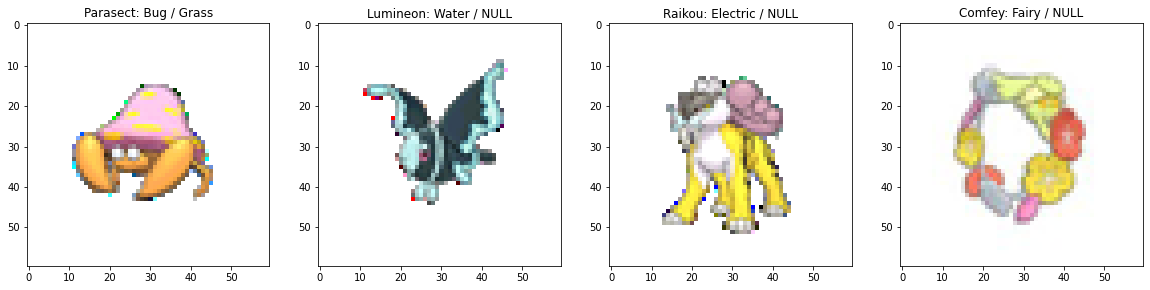

In [32]:
plt.figure(figsize=(20, 5))

# Original image
plt.subplot(1,4,1)
plt.title(str(name_label_data[0]) + ": " + str(oh_decoder(oh_lables[0])))
plt.imshow(training_data[0])

# Flipped | image
plt.subplot(1,4,2)
plt.title(str(name_label_data[4]) + ": " + str(oh_decoder(oh_lables[4])))
plt.imshow(training_data[4])

# Flipped -- image
plt.subplot(1,4,3)
plt.title(str(name_label_data[8]) + ": " + str(oh_decoder(oh_lables[8])))
plt.imshow(training_data[8])

# Double flipped image
plt.subplot(1,4,4)
plt.title(str(name_label_data[12]) + ": " + str(oh_decoder(oh_lables[12])))
plt.imshow(training_data[12])

plt.show()

# Splitting Training and Testing Data

The dataset must be split between training and testing data. If the same data is used for training and testing, the model will become overfitted to the training data and accuracy results will appear to be much higher than any real-world example would produce. 

In [38]:
split = 0.9

# Defining training/testing split 
datasplit = int(len(training_data)*split)

# Defining the training and testing datasets /// Normalisation of pixel data between 0-1
x_train = training_data[:datasplit].astype('float32') / 255.
x_test = training_data[datasplit:].astype('float32') / 255.

y_train = oh_lables[:datasplit]
y_test = oh_lables[datasplit:]

print("Unsplit data:  " + str(training_data.shape) + "\n")
print("Training data: " + str(x_train.shape))
print("Testing labels: " + str(y_test.shape) + "\n")
print("Testing data:  " + str(x_test.shape))
print("Training labels: " + str(y_train.shape))


Unsplit data:  (14360, 60, 60, 3)

Training data: (12924, 60, 60, 3)
Testing labels: (1436, 18)

Testing data:  (1436, 60, 60, 3)
Training labels: (12924, 18)


# Break Point
# .
# .
# . 
# .

In [74]:
stats = np.zeros((809,12))
poke_id = []
name = []
type1 = []
type2 = []


print(stats.shape)

(809, 12)


In [75]:
filepath = 'Dataset/pokemon.csv'
last_id = 0 

with open(filepath) as pokemon_stats:
    row_pokemon = csv.DictReader(pokemon_stats)
    for idx, row in enumerate(row_pokemon):
        if(row['#'] != last_id):
            last_id = row['#']
            poke_id.append(row['#'])
            name.append(row['Name'])
            type1.append(row['Type 1'])

            if(row['Type 2'] != ""):
                type2.append(row['Type 2'])
            else:
                type2.append(row['Type 1'])
            

In [76]:
for x in range(10):
    print(poke_id[x])
    print(name[x])
    print(type1[x])
    print(type2[x])
  
    print()
    

1
Bulbasaur
Grass
Poison

2
Ivysaur
Grass
Poison

3
Venusaur
Grass
Poison

4
Charmander
Fire
Fire

5
Charmeleon
Fire
Fire

6
Charizard
Fire
Flying

7
Squirtle
Water
Water

8
Wartortle
Water
Water

9
Blastoise
Water
Water

10
Caterpie
Bug
Bug



In [77]:
if(len(name) == len(name_label_data)):
    print("True")

    
print(len(name))
print(len(name_label_data))
print(len(name_label_data)/len(name))

809
12820
15.84672435105068


In [78]:
id_label_data = []

# loop through name labels 
# compare name in csv to name label - loop through all names in csv
# if match append poke_id to id_label_data
# important as there may be multiple pokemon with the same name
found = 0
for x in range(len(name_label_data)):
    found = 0
  
    try:
        nameid = int(name_label_data[x])
      
    except:
    
        for y in range(len(name)):
            if(name_label_data[x] in name[y].lower()):
                found = 1
                id_label_data.append(y+1)
                break
    else:
      
        for y in range(len(name)):
            if(nameid == int(poke_id[y])):
                found = 1
                id_label_data.append(y+1)
   
                break
            
    if(found == 0):
        print(name_label_data[x])
    

scizor-f
scizor-f
scizor-f
scizor-f


In [79]:
for x in range (len(name_label_data)):
    print(name_label_data[x])

parasect
parasect
parasect
parasect
lumineon
lumineon
lumineon
lumineon
raikou
raikou
raikou
raikou
comfey
comfey
comfey
comfey
dedenne
dedenne
dedenne
dedenne
pyroar
pyroar
pyroar
pyroar
articuno
articuno
articuno
articuno
magmortar
magmortar
magmortar
magmortar
bulbasaur
bulbasaur
bulbasaur
bulbasaur
mrmime
mrmime
mrmime
mrmime
banette
banette
banette
banette
staraptor
staraptor
staraptor
staraptor
pidove
pidove
pidove
pidove
taillow
taillow
taillow
taillow
charizard
charizard
charizard
charizard
infernape
infernape
infernape
infernape
sandshrew
sandshrew
sandshrew
sandshrew
alakazam
alakazam
alakazam
alakazam
lickitung
lickitung
lickitung
lickitung
starmie
starmie
starmie
starmie
yanmega
yanmega
yanmega
yanmega
yveltal
yveltal
yveltal
yveltal
zigzagoon
zigzagoon
zigzagoon
zigzagoon
thundurus
thundurus
thundurus
thundurus
petilil
petilil
petilil
petilil
torterra
torterra
torterra
torterra
purugly
purugly
purugly
purugly
cresselia
cresselia
cresselia
cresselia
regigigas
regigigas
regi

minun
minun
minun
minun
heracross
heracross
heracross
heracross
trapinch
trapinch
trapinch
trapinch
girafarig
girafarig
girafarig
girafarig
tyrantrum
tyrantrum
tyrantrum
tyrantrum
graveler
graveler
graveler
graveler
poochyena
poochyena
poochyena
poochyena
electivire
electivire
electivire
electivire
gourgeist
gourgeist
gourgeist
gourgeist
cosmog
cosmog
cosmog
cosmog
ledian
ledian
ledian
ledian
torracat
torracat
torracat
torracat
cherrim
cherrim
cherrim
cherrim
primeape
primeape
primeape
primeape
vanillish
vanillish
vanillish
vanillish
probopass
probopass
probopass
probopass
skiploom
skiploom
skiploom
skiploom
chesnaught
chesnaught
chesnaught
chesnaught
kyurem
kyurem
kyurem
kyurem
melmetal
melmetal
melmetal
melmetal
shiinotic
shiinotic
shiinotic
shiinotic
popplio
popplio
popplio
popplio
carnivine
carnivine
carnivine
carnivine
gardevoir
gardevoir
gardevoir
gardevoir
jrmime
jrmime
jrmime
jrmime
pinsir
pinsir
pinsir
pinsir
snorunt
snorunt
snorunt
snorunt
samurott
samurott
samurott
samurott


chingling
chingling
chingling
chingling
blacephalon
blacephalon
blacephalon
blacephalon
whirlipede
whirlipede
whirlipede
whirlipede
ferroseed
ferroseed
ferroseed
ferroseed
barbaracle
barbaracle
barbaracle
barbaracle
salamence
salamence
salamence
salamence
zekrom
zekrom
zekrom
zekrom
haunter
haunter
haunter
haunter
glaceon
glaceon
glaceon
glaceon
shaymin
shaymin
shaymin
shaymin
golduck
golduck
golduck
golduck
milotic
milotic
milotic
milotic
politoed
politoed
politoed
politoed
absol
absol
absol
absol
mienshao
mienshao
mienshao
mienshao
aron
aron
aron
aron
tepig
tepig
tepig
tepig
toucannon
toucannon
toucannon
toucannon
klang
klang
klang
klang
zapdos
zapdos
zapdos
zapdos
clauncher
clauncher
clauncher
clauncher
riolu
riolu
riolu
riolu
raichu
raichu
raichu
raichu
hitmonchan
hitmonchan
hitmonchan
hitmonchan
slakoth
slakoth
slakoth
slakoth
ponyta
ponyta
ponyta
ponyta
togepi
togepi
togepi
togepi
pumpkaboo
pumpkaboo
pumpkaboo
pumpkaboo
snover
snover
snover
snover
solosis
solosis
solosis
solosis


038
789
789
789
789
212
212
212
212
574
574
574
574
560
560
560
560
206
206
206
206
548
548
548
548
549
549
549
549
561
561
561
561
207
207
207
207
213
213
213
213
575
575
575
575
788
788
788
788
039
039
039
039
005
005
005
005
763
763
763
763
777
777
777
777
011
011
011
011
159
159
159
159
171
171
171
171
617
617
617
617
603
603
603
603
165
165
165
165
398
398
398
398
429
429
429
429
415
415
415
415
373
373
373
373
367
367
367
367
401
401
401
401
371
371
371
371
417
417
417
417
403
403
403
403
365
365
365
365
359
359
359
359
615
615
615
615
173
173
173
173
167
167
167
167
601
601
601
601
629
629
629
629
198
198
198
198
761
761
761
761
007
007
007
007
013
013
013
013
775
775
775
775
749
749
749
749
205
205
205
205
563
563
563
563
577
577
577
577
211
211
211
211
239
239
239
239
588
588
588
588
589
589
589
589
238
238
238
238
576
576
576
576
210
210
210
210
204
204
204
204
562
562
562
562
748
748
748
748
012
012
012
012
774
774
774
774
760
760
760
760
006
006
006
006
199
199
199
199
628


781
781
781
795
795
795
795
018
018
018
018
024
024
024
024
742
742
742
742
756
756
756
756
030
030
030
030
805
805
805
805
193
193
193
193
187
187
187
187
178
178
178
178
150
150
150
150
636
636
636
636
622
622
622
622
144
144
144
144
391
391
391
391
385
385
385
385
408
408
408
408
434
434
434
434
352
352
352
352
346
346
346
346
420
420
420
420
350
350
350
350
436
436
436
436
422
422
422
422
344
344
344
344
378
378
378
378
393
393
393
393
387
387
387
387
634
634
634
634
152
152
152
152
146
146
146
146
620
620
620
620
608
608
608
608
191
191
191
191
185
185
185
185
807
807
807
807
740
740
740
740
026
026
026
026
032
032
032
032
754
754
754
754
768
768
768
768
783
783
783
783
797
797
797
797
224
224
224
224
542
542
542
542
556
556
556
556
230
230
230
230
218
218
218
218
581
581
581
581
595
595
595
595
594
594
594
594
580
580
580
580
219
219
219
219
557
557
557
557
231
231
231
231
225
225
225
225
543
543
543
543
796
796
796
796
782
782
782
782
769
769
769
769
033
033
033
033
755
755
755


eevee
eevee
mewtwo
mewtwo
mewtwo
mewtwo
buneary
buneary
buneary
buneary
kabutops
kabutops
kabutops
kabutops
palkia
palkia
palkia
palkia
ninetales
ninetales
ninetales
ninetales
sableye
sableye
sableye
sableye
bidoof
bidoof
bidoof
bidoof
vivillon
vivillon
vivillon
vivillon
ninetales
ninetales
ninetales
ninetales
goldeen
goldeen
goldeen
goldeen
flabebe
flabebe
flabebe
flabebe
snorlax
snorlax
snorlax
snorlax
braixen
braixen
braixen
braixen
gligar
gligar
gligar
gligar
grimer
grimer
grimer
grimer
mewtwo
mewtwo
mewtwo
mewtwo
nidorino
nidorino
nidorino
nidorino
elgyem
elgyem
elgyem
elgyem
sandslash
sandslash
sandslash
sandslash
golem
golem
golem
golem
gloom
gloom
gloom
gloom
electabuzz
electabuzz
electabuzz
electabuzz
piloswine
piloswine
piloswine
piloswine
vivillon
vivillon
vivillon
vivillon
miltank
miltank
miltank
miltank
minior
minior
minior
minior
dialga
dialga
dialga
dialga
guzzlord
guzzlord
guzzlord
guzzlord
cinccino
cinccino
cinccino
cinccino
gardevoir
gardevoir
gardevoir
gardevoir
pilo

magneton
blaziken
blaziken
blaziken
blaziken
pikachu
pikachu
pikachu
pikachu
mesprit
mesprit
mesprit
mesprit
basculin
basculin
basculin
basculin
psyduck
psyduck
psyduck
psyduck
groudon
groudon
groudon
groudon
wobbuffet
wobbuffet
wobbuffet
wobbuffet
delphox
delphox
delphox
delphox
meowth
meowth
meowth
meowth
exploud
exploud
exploud
exploud
mantyke
mantyke
mantyke
mantyke
malamar
malamar
malamar
malamar
grimer
grimer
grimer
grimer
koffing
koffing
koffing
koffing
aerodactyl
aerodactyl
aerodactyl
aerodactyl
simisage
simisage
simisage
simisage
espeon
espeon
espeon
espeon
landorus
landorus
landorus
landorus
nidoran
nidoran
nidoran
nidoran
oddish
oddish
oddish
oddish
golem
golem
golem
golem
paras
paras
paras
paras
noctowl
noctowl
noctowl
noctowl
delibird
delibird
delibird
delibird
dragonite
dragonite
dragonite
dragonite
hitmonlee
hitmonlee
hitmonlee
hitmonlee
zubat
zubat
zubat
zubat
slaking
slaking
slaking
slaking
florges
florges
florges
florges
meowth
meowth
meowth
meowth
vivillon
vivillon
v

staravia
staravia
staravia
linoone
linoone
linoone
linoone
marowak
marowak
marowak
marowak
magikarp
magikarp
magikarp
magikarp
spiritomb
spiritomb
spiritomb
spiritomb
zoroark
zoroark
zoroark
zoroark
primeape
primeape
primeape
primeape
chikorita
chikorita
chikorita
chikorita
vanillite
vanillite
vanillite
vanillite
bellsprout
bellsprout
bellsprout
bellsprout
rotom
rotom
rotom
rotom
scatterbug
scatterbug
scatterbug
scatterbug
spinda
spinda
spinda
spinda
beheeyem
beheeyem
beheeyem
beheeyem
grimer
grimer
grimer
grimer
butterfree
butterfree
butterfree
butterfree
rotom
rotom
rotom
rotom
xerneas
xerneas
xerneas
xerneas
leafeon
leafeon
leafeon
leafeon
wigglytuff
wigglytuff
wigglytuff
wigglytuff
cubone
cubone
cubone
cubone
meganium
meganium
meganium
meganium
scyther
scyther
scyther
scyther
hoothoot
hoothoot
hoothoot
hoothoot
celebi
celebi
celebi
celebi
popplio
popplio
popplio
popplio
breloom
breloom
breloom
breloom
graveler
graveler
graveler
graveler
turtwig
turtwig
turtwig
turtwig
zweilous
zwei

chansey
chansey
uxie
uxie
uxie
uxie
krabby
krabby
krabby
krabby
suicune
suicune
suicune
suicune
bewear
bewear
bewear
bewear
sudowoodo
sudowoodo
sudowoodo
sudowoodo
bergmite
bergmite
bergmite
bergmite
pikachu
pikachu
pikachu
pikachu
lanturn
lanturn
lanturn
lanturn
arceus
arceus
arceus
arceus
aggron
aggron
aggron
aggron
decidueye
decidueye
decidueye
decidueye
lickitung
lickitung
lickitung
lickitung
girafarig
girafarig
girafarig
girafarig
kingler
kingler
kingler
kingler
shroomish
shroomish
shroomish
shroomish
gligar
gligar
gligar
gligar
sylveon
sylveon
sylveon
sylveon
swampert
swampert
swampert
swampert
genesect
genesect
genesect
genesect
roselia
roselia
roselia
roselia
manectric
manectric
manectric
manectric
bonsly
bonsly
bonsly
bonsly
zeraora
zeraora
zeraora
zeraora
type
type
type
type
treecko
treecko
treecko
treecko
spearow
spearow
spearow
spearow
combusken
combusken
combusken
combusken
flareon
flareon
flareon
flareon
manectric
manectric
manectric
manectric
beedrill
beedrill
beedrill
b

In [58]:
print(len(id_label_data))

12820


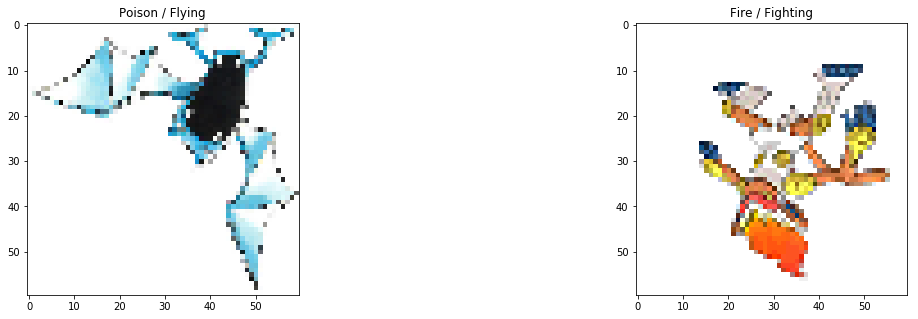

In [86]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.title(str(type1[id_label_data[-1]-1]) + " / " + str(type2[id_label_data[-1]-1]))
plt.imshow(training_data[-1])


plt.subplot(1,2,2)
plt.title(str(type1[id_label_data[62]-1]) + " / " + str(type2[id_label_data[62]-1]))
plt.imshow(training_data[62])
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_data = []
one_hot_labels = []


types = ["Bug","Dark","Dragon","Electric","Fairy","Fighting",
        "Fire","Flying","Ghost","Grass","Ground","Ice",
        "Normal","Poison","Psychic","Rock","Steel","Water"]

for x in range(len(training_data)):
    for y in range(len(types)):
        #label_data.append(type1[id_label_data[x]-1])
        if(type1[id_label_data[x]-1] == types[y]):
            label_data.append(y)

counter = 0
for x in range(len(id_label_data)):
    found = 0
    #print("ID: " + str(id_label_data[x]))
    #print("Name: " + str(name_label_data[x]))
    #print("Type 1: " + str(type1[id_label_data[x]-1]))
    #print("Type 2: " + str(type2[id_label_data[x]-1]))
    
    for y in range(len(types)):
        if(type1[id_label_data[x]-1] == types[y]):
            temp = to_categorical(y, 18)
            if(type1[id_label_data[x]-1] != type2[id_label_data[x]-1]):
               # print("Test")
                for z in range(len(types)):
                    #print(str(type2[id_label_data[z]-1]) + " ---- " + str(types[z]))
                    if(type2[id_label_data[x]-1] == types[z]):
                        #print("Test2")
                        temp2 = to_categorical(z, 18)
                        temp = temp + temp2
                        print(temp)
            
            one_hot_labels.append(temp)
            found = 1
    #print(temp)
    #print()
    if(found==0):
        print("error")
    counter += 1
    
y_train = np.zeros((x_train.shape[0], 18))
y_test = np.zeros((x_test.shape[0], 18))
for x in range(y_train.shape[0]):
    for y in range(y_train.shape[1]):
        y_train[x][y] = one_hot_labels[x][y]
    
for x in range(y_test.shape[0]):
    for y in range(y_test.shape[1]):
        y_test[x][y] = one_hot_labels[x_train.shape[0]+x][y]

## Building the CNN

In [39]:
channels = 3
img_shape = (img_size, img_size, channels)
num_classes = 18
print(y_train.shape)
print(x_train.shape)

(12924, 18)
(12924, 60, 60, 3)


In [41]:
for x in range(100):
    if(x%4==0):
        print(y_train[x])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.

In [48]:
def create_model():
    model = keras.Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=img_shape))
    model.add(Conv2D(32, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(num_classes, activation="softmax"))
    
    return model

In [49]:
def create_model2():
    model = keras.Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=img_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [50]:
def create_model3():
    model = keras.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=img_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [ ]:
model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64)

Epoch 1/50
202/202 [==============================] - 90s 446ms/step - loss: 16073.2287 - accuracy: 0.0640 - val_loss: 189387.0781 - val_accuracy: 0.0961
Epoch 2/50
202/202 [==============================] - 89s 438ms/step - loss: 298437.4169 - accuracy: 0.0732 - val_loss: 1017596.5000 - val_accuracy: 0.0759
Epoch 3/50
182/202 [==========================>...] - ETA: 8s - loss: 906882.9887 - accuracy: 0.0738

In [ ]:
model = create_model2()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64)

In [ ]:
model = create_model3()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64)

In [ ]:
#plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_acc'], label='val_acc')
plt.plot(history.history['acc'], label= 'accuracy')
plt.legend()
#plt.ylim(0,1)
plt.show()


In [ ]:
# plot testing accuracy
plt.figure(2, figsize=(10,10))
ax1 = plt.subplot(1, 1, 1)

ax1.plot(history.history['acc'], label='Accuracy - Model 1')
ax1.plot(history2.history['acc'], label='Accuracy - Model 2')
ax1.plot(history3.history['acc'], label='Accuracy - Model 3')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Training Accuracy', size=20)
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.legend()
plt.show()


# plot validation accuracy
plt.figure(2, figsize=(10,10))
ax2 = plt.subplot(1, 1, 1)
ax2.plot(history.history['val_acc'], label='Accuracy - Model 1')
ax2.plot(history2.history['val_acc'], label='Accuracy - Model 2')
ax2.plot(history3.history['val_acc'], label='Accuracy - Model 3')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Validation Accuracy', size=20)
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.legend()
plt.show()

# plot testing loss
plt.figure(2, figsize=(10,10))
ax2 = plt.subplot(1, 1, 1)
ax2.plot(history.history['loss'], label='Loss - Model1')
ax2.plot(history2.history['loss'], label='Loss - Model 2')
ax2.plot(history3.history['loss'], label='Loss - Model 3')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Training Loss', size=20)
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.legend()
plt.show()


# plot testing loss
plt.figure(2, figsize=(10,10))
ax2 = plt.subplot(1, 1, 1)
ax2.plot(history.history['val_loss'], label='Loss - Model 1')
ax2.plot(history2.history['val_loss'], label='Loss - Model 2')
ax2.plot(history3.history['val_loss'], label='Loss - Model 3')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Validation Loss', size=20)
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.legend()
plt.show()


## Building the GAN

In [ ]:
#Specify parameters of the training dataset
latent_dim = 100
x_train_gan = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_gan = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [ ]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    '''
    generator.add(Dense(units=1024*2))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024*4))
    generator.add(LeakyReLU(0.2))
    '''
    generator.add(Dense(units=np.prod(img_shape), activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator


g = create_generator()
g.summary()

In [ ]:
def create_discriminator():
    discriminator=Sequential()
    '''
    discriminator.add(Dense(units=1024*4,input_dim=np.prod(img_shape)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=1024*2))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    '''
    discriminator.add(Dense(units=1024,input_dim=np.prod(img_shape)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d = create_discriminator()
d.summary()

In [ ]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

In [ ]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,img_size,img_size,3)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [ ]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    batch_count = x_train_gan.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =x_train_gan[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
            
training(2880,128)

Todo....

- More images
- Flip Images
- Setup CNN
- Find model with premade weights
